In [5]:
import os
import numpy as np
%matplotlib inline

import keras.models as models
import keras.layers as layers
import keras.optimizers as optimizers

from keras.applications import VGG16
from keras.preprocessing.image import ImageDataGenerator

In [6]:
def plot_history(history):
    history_data        = history.history

    train_accuracy      = history_data['acc']
    train_loss          = history_data['loss']
    validation_accuracy = history_data['val_acc']
    validation_loss     = history_data['val_loss']

    epochs              = range(1, len(history_data['acc']) + 1)

    f, (left, right) = plt.subplots(1, 2)
    f.set_size_inches(16,4)

    left.plot(epochs, train_loss, 'bo', label='Training loss')
    left.plot(epochs, validation_loss, 'b', label='Validation loss')
    left.set_title('Training and validation loss')
    left.set_xlabel('Epochs')
    left.set_ylabel('Loss')
    left.legend()

    right.plot(epochs, train_accuracy, 'bo', label='Training accuracy')
    right.plot(epochs, validation_accuracy, 'b', label='Validation accuracy')
    right.set_title('Training and validation accuracy')
    right.set_xlabel('Epochs')
    right.set_ylabel('Accuracy')
    right.legend()
    
    plt.show()

def plot_accuracy_history(originalModelHistory, otherModelHistory):

    original_validation_loss = originalModelHistory.history['val_loss']
    other_validation_loss    = otherModelHistory.history['val_loss']
    epochs                   = range(1, len(original_validation_loss) + 1)

    f, left = plt.subplots(1, 1)
    f.set_size_inches(12,4)

    left.plot(epochs, original_validation_loss, 'bo', label='Original model validation loss')
    left.plot(epochs, other_validation_loss, 'b', label='Other model validation loss')
    left.set_title('Training and validation loss')
    left.set_xlabel('Epochs')
    left.set_ylabel('Validation loss')
    left.legend()

    plt.show()

In [7]:
convolutional_base = VGG16(weights = 'imagenet', include_top = False, input_shape = (150,150,3))
convolutional_base.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 150, 150, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 37, 37, 128)       0         
__________

In [15]:
def extract_features(dataset, samplesCount):
    features = np.zeros(shape = (samplesCount, 4, 4, 512))
    labels = np.zeros(samplesCount)
    
    imagesGenerator =  ImageDataGenerator(rescale = 1./255).flow_from_directory(
        directory = dataset,
        target_size=(150,150),
        batch_size=20,
        class_mode='binary'
    )
    
    currentBatch = 0
    
    for images, correctLabels in imagesGenerator:
        features[currentBatch * 20 : (currentBatch + 1) * 20] = convolutional_base.predict(images)
        labels[currentBatch * 20 : (currentBatch + 1) * 20] = correctLabels
        currentBatch += 1
        
        if(currentBatch * 20) >= samplesCount:
            break;
    return features, labels

trainFeatures, trainLabels = extract_features(os.path.join(os.getcwd(), 'datasets/training/train'), 2000)
validationFeatures, validationLabels = extract_features(os.path.join(os.getcwd(), 'datasets/training/validation'), 1000)
testFeatures, testLabels = extract_features(os.path.join(os.getcwd(), 'datasets/training/test'), 1000)

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


In [17]:
model = models.Sequential()
model.add(layers.Dense(256, activation = 'relu', input_dim = 4 * 4 * 512))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(1, activation = 'sigmoid'))

model.compile(
    loss='binary_crossentropy',
    optimizer=optimizers.RMSprop(lr=2e-5),
    metrics=['accuracy']
)

trainFeatures      = np.reshape(trainFeatures, (2000, 4 * 4 * 512))
validationFeatures = np.reshape(validationFeatures, (1000, 4 * 4 * 512))
testFeatures       = np.reshape(testFeatures, (1000, 4 * 4 * 512))

history = model.fit(
      trainFeatures, trainLabels,
      epochs=30,
      batch_size = 20,
      validation_data=(validationFeatures, validationLabels)
)

Train on 2000 samples, validate on 1000 samples
Epoch 1/30
2000/2000 [==============================] - 1s 721us/step - loss: 0.5741 - acc: 0.7105 - val_loss: 0.4418 - val_acc: 0.8400
Epoch 2/30
2000/2000 [==============================] - 1s 559us/step - loss: 0.4140 - acc: 0.8290 - val_loss: 0.3626 - val_acc: 0.8640
Epoch 3/30
2000/2000 [==============================] - 1s 570us/step - loss: 0.3497 - acc: 0.8520 - val_loss: 0.3271 - val_acc: 0.8740
Epoch 4/30
2000/2000 [==============================] - 1s 567us/step - loss: 0.3004 - acc: 0.8790 - val_loss: 0.3004 - val_acc: 0.8840
Epoch 5/30
2000/2000 [==============================] - 1s 558us/step - loss: 0.2900 - acc: 0.8780 - val_loss: 0.2913 - val_acc: 0.8810
Epoch 6/30
2000/2000 [==============================] - 1s 596us/step - loss: 0.2647 - acc: 0.8925 - val_loss: 0.2859 - val_acc: 0.8800
Epoch 7/30
2000/2000 [==============================] - 1s 564us/step - loss: 0.2386 - acc: 0.9010 - val_loss: 0.2667 - val_acc: 0.8960


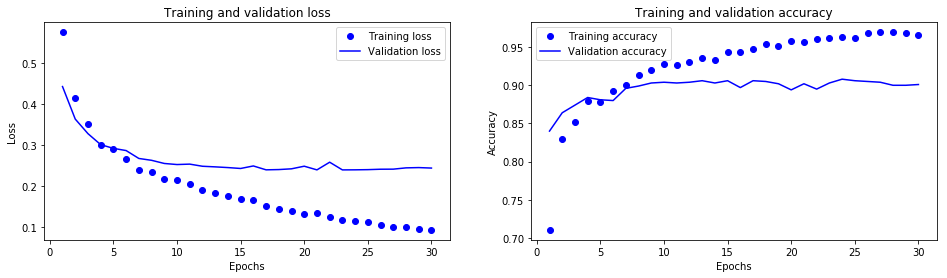

1000/1000 [==============================] - 0s 149us/step
[0.25458777379989622, 0.88800000000000001]


In [19]:
plot_history(history)
print(model.evaluate(testFeatures, testLabels))

In [20]:
model.save('transfer-learning-with-feature-extraction.h5')